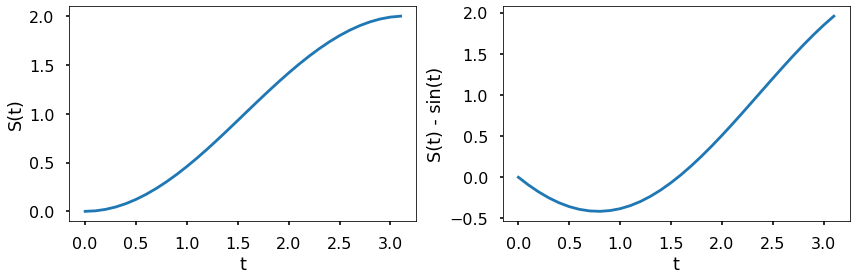

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import rheosys as rhs

plt.style.use('seaborn-poster')


F = lambda t, s: np.sin(t)

t_eval = np.arange(0, np.pi, 0.1)
sol = solve_ivp(F, [0, np.pi], [0], t_eval=t_eval)

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.subplot(122)
plt.plot(sol.t, sol.y[0] - np.sin(sol.t))
plt.xlabel('t')
plt.ylabel('S(t) - sin(t)')
plt.tight_layout()
plt.show()

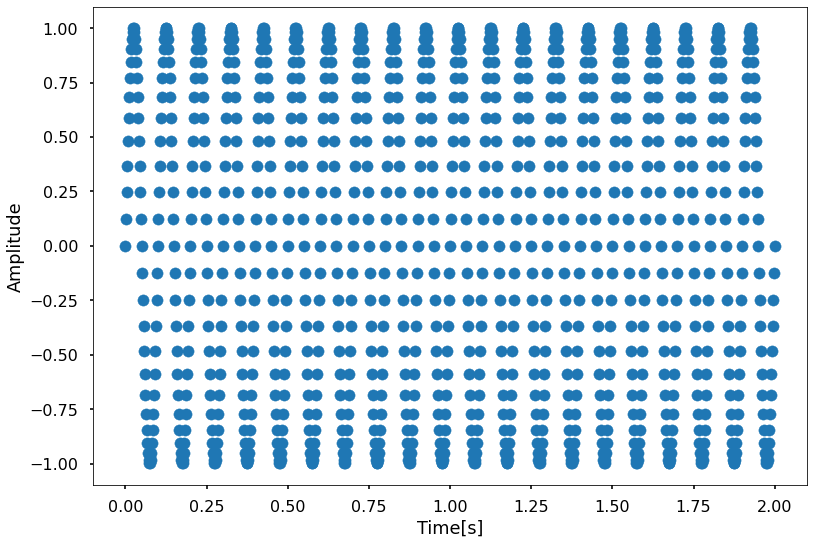

In [173]:
import numpy as np


def u_continuous(time):
    u=np.sin(time)
    return u


def u_sampling (excitation_frequency,sample_frequency,sample_time):
    f0=excitation_frequency                     # f0 = excitation wave frequency [Hz]
    Fs=sample_frequency                         # Fs = sampling frequency [Hz]
    T=sample_time                               # Record window duration [s]

    dt = 1/Fs                                   # Sampling period [s]
    t = np.arange(0,T+dt,dt)   # Time vector for sampling [s]

    # generate samples at the specified times
    u_sampled = np.sin(2*np.pi*f0*t); # [signal units]

    return (t,u_sampled)

#run the function
u,time= u_sampling(10,500,2)
t_test=np.arange(0,10,0.0002)
u2=u_continuous(t_test)

plt.scatter(u,time)
#plt.plot(t_test,u2)
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()



<class 'numpy.ndarray'> [ 0.00000000e+00 -7.07106781e-01 -1.00000000e+00 -7.07106781e-01
  5.38968388e-15  7.07106781e-01  1.00000000e+00  7.07106781e-01
 -1.07793678e-14 -7.07106781e-01 -1.00000000e+00 -7.07106781e-01
  3.03799063e-14  7.07106781e-01  1.00000000e+00  7.07106781e-01
 -2.15587355e-14]
<class 'float'> 0.125
<class 'int'> 2
0.0


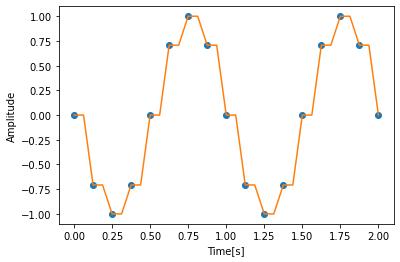

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from math import floor

def u_continuous(time):
    u=np.sin(time)
    return u


def u_sampling (excitation_frequency,sample_frequency,sample_time):
    f0=excitation_frequency                     # f0 = excitation wave frequency [Hz]
    Fs=sample_frequency                         # Fs = sampling frequency [Hz]
    T=sample_time                               # Record window duration [s]

    dt = 1/Fs                                   # Sampling period [s]
    t = np.arange(0,T+dt,dt)   # Time vector for sampling [s]

    # generate samples at the specified times
    u_sampled = np.sin(2*np.pi*f0*t); # [signal units]

    return (u_sampled,t)


f_excitation=15
f_sample=8
T_sample=1/f_sample
T_total=2


#run the function
u_d,time= u_sampling(f_excitation,f_sample,T_total)

#print(u_d)

print(type(u_d),u_d)
print(type(T_sample),T_sample)
print(type(T_total),T_total)

def DAC_0 (u_discrete,sample_time,x):
    u_test=u_discrete[floor(sample_time/x)]

    return u_test


print(DAC_0(u_d,T_sample,28))

t = np.arange(0,T_total+T_sample,T_sample)
t2 = np.arange(0,T_total+(T_sample/2),T_sample/2)

# Calculating the Discrete to Analog by interpolation between the sampled points
# This interpolation can adress the orders 0 to 2 and every positive odd number
u_t=interp1d(t,u_d,kind=0)

x = t
y = u_d
xnew = t2
ynew = u_t(xnew)   # use interpolation function returned by `interp1d`


F = lambda t, s:ynew

t_eval = t


plt.plot(x, y, 'o', xnew, ynew, '-')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()


# theta''(t) + b*theta'(t) + c*sin(theta(t)) = 0




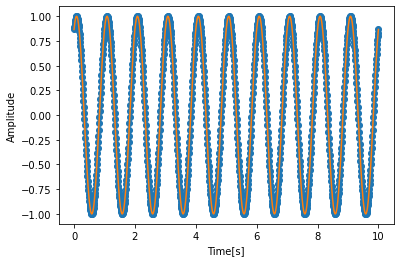

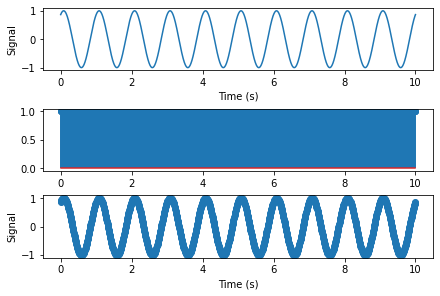

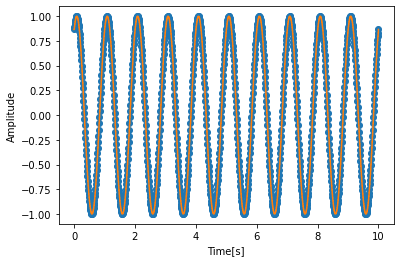

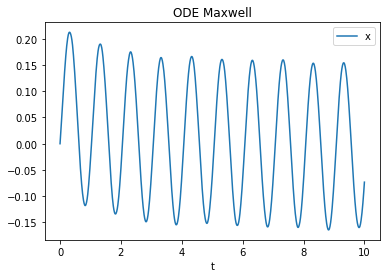

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

#define excitation varibales
f_s = 100               # Sample frequency
T_s = 1/f_s             # Sampling time
T = 10                  # Time interval of total test
f_e = 1                 # Excitation frequency
phi = np.pi/3           # Signal phase
nCT = 100                # Oversampling points for continuous time plots

NDT=T*f_s               # Number of discrete points
NCT=T*f_s*nCT           # Number of cointinuous point
t_DT= np.arange(0, T+T_s, T_s)              # Discrete-time vector
t_CT= np.arange(0, T+(T_s/nCT), (T_s/nCT))  # Continuous-time vector

def sine (period):
    return np.sin(period)

u_DT=sine(2*np.pi*f_e*t_DT+phi)
u_CT=sine(2*np.pi*f_e*t_CT+phi)

plt.plot(t_DT, u_DT, "o", t_CT, u_CT, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

fig, (ax0, ax1,ax2) = plt.subplots(3, 1, layout='constrained')
ax0.plot(t_CT, u_CT,'-')
ax1.stem(t_DT,np.ones(np.size(t_DT)))
ax2.plot(t_DT,u_DT,'o')

for ax in ax0,ax2:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal')

plt.show()

def DAC_0(u_discrete, sample_time, time_range):
    u_test = []
    for i in range(len(time_range)):
        x = int(time_range[i]//sample_time)
        u_test.append(u_discrete[x])
    return np.array(u_test)



# run the function
u_T = DAC_0(u_d, T_sample, t2)

# Alternative calculation of u_t, by use of scipy interpolation, kind is 0,2 and all odd numbers
u_interp=interp1d(t_DT,u_DT,kind=0)
u_t_interp = u_interp(t_CT)


plt.plot(t_DT, u_DT, "o", t_CT, u_t_interp, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

def gamma_dot(t):
    return u_interp(t)

# waarom moet je de waardes voor
# tau_dot=G*gamma_dot(t) -1/lambda *tau
def ODE_maxwell(t, tau, L,G):
    #L,G=args
    return G*gamma_dot(t) - tau/L

sol = solve_ivp(ODE_maxwell, [0, T], [0], args=(1.5, 1), t_eval=t_DT)


plt.plot(np.squeeze(t_DT), np.squeeze(sol.y))
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=False)
plt.title('ODE Maxwell')
plt.show()

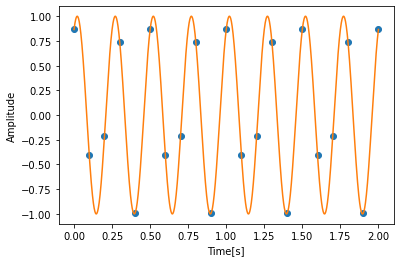

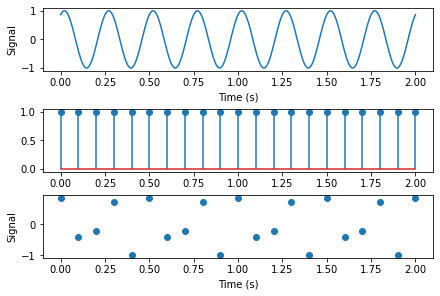

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

#define excitation varibales
f_s = 10               # Sample frequency
T_s = 1/f_s             # Sampling time
T = 2                  # Time interval of total test
f_e = 4                 # Excitation frequency
phi = np.pi/3           # Signal phase
nCT = 100                # Oversampling points for continuous time plots

NDT=T*f_s               # Number of discrete points
NCT=T*f_s*nCT           # Number of cointinuous point
t_DT= np.arange(0, T+T_s, T_s)              # Discrete-time vector
t_CT= np.arange(0, T+(T_s/nCT), (T_s/nCT))  # Continuous-time vector

def sine (period):
    return np.sin(period)

u_D=sine(2*np.pi*f_e*t_DT+phi)
u_C=sine(2*np.pi*f_e*t_CT+phi)

plt.plot(t_DT, u_D, "o", t_CT, u_C, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

fig, (ax0, ax1,ax2) = plt.subplots(3, 1, layout='constrained')
ax0.plot(t_CT, u_C,'-')
ax1.stem(t_DT,np.ones(np.size(t_DT)))
ax2.plot(t_DT,u_D,'o')

for ax in ax0,ax2:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal')

plt.show()